In [1]:
import os
import requests

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
COLORS = sns.color_palette('colorblind')

## Content Table:
* [Data Metrics](#1-bullet)
* [Model Metrics](#2-bullet)

In [2]:
if os.getenv('CONTAINER_BASE_DIR'):
    API_DIRECTORY_URL = 'http://api:8080/'
    directory = requests.get(API_DIRECTORY_URL).json()
    directory['result'] = {k: v.replace('localhost', 'api') for k, v in directory['result'].items()}
else:
    API_DIRECTORY_URL = 'http://localhost:8080/'
    directory = requests.get(API_DIRECTORY_URL).json()

In [3]:
raw_df_data = requests.get(directory['result']['get_dataframe_data']).json()
raw_model_data = requests.get(directory['result']['get_model_data']).json()

## Data Metrics <a class="anchor" id="1-bullet"></a>

In [4]:
data_to_create_df = []
for record in raw_df_data['result']:
    data_to_create_df = data_to_create_df + record['message']['data']

In [5]:
df_data = pd.DataFrame(data_to_create_df)

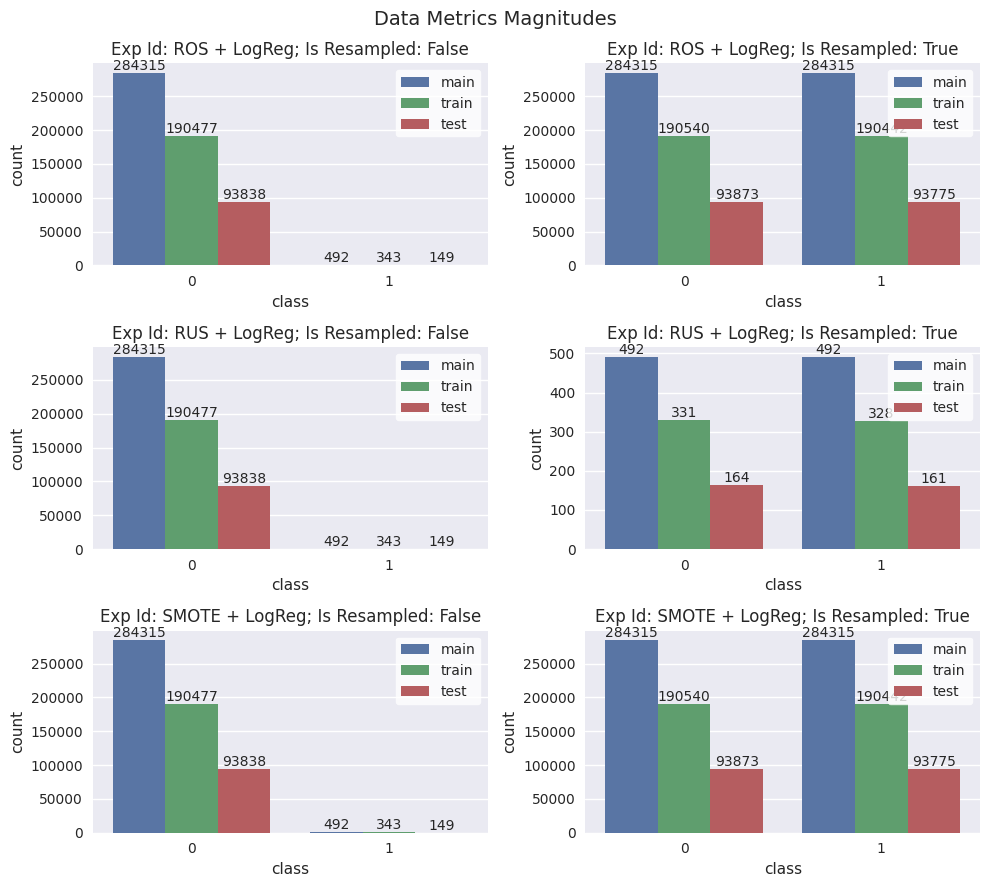

In [6]:
_ = plt.figure(figsize=[10, 9])
plt.suptitle('Data Metrics Magnitudes', fontsize=14)

for i, exp in enumerate(df_data['exp_id'].unique()):
    data = df_data[df_data['exp_id'] == exp]
    
    index = (i * 2) + 1
    
    plt.subplot(3,2,index)
    ros_log_original = data[~data['is_resampled']]
    ax = sns.barplot(
        data=ros_log_original, 
        x='class', 
        y='count',
        hue='subset')
    for container in ax.containers:
        ax.bar_label(container)
    ax.set_ylabel('count')
    plt.title(f'Exp Id: {exp}; Is Resampled: False')
    legend = plt.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_color('white')

    plt.subplot(3,2,index+1)
    ros_log_resampled = data[data['is_resampled']]
    ax = sns.barplot(
        data=ros_log_resampled, 
        x='class', 
        y='count',
        hue='subset')
    for container in ax.containers:
        ax.bar_label(container)
    ax.set_ylabel('count')
    plt.title(f'Exp Id: {exp}; Is Resampled: True')
    legend = plt.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_color('white')

plt.tight_layout()

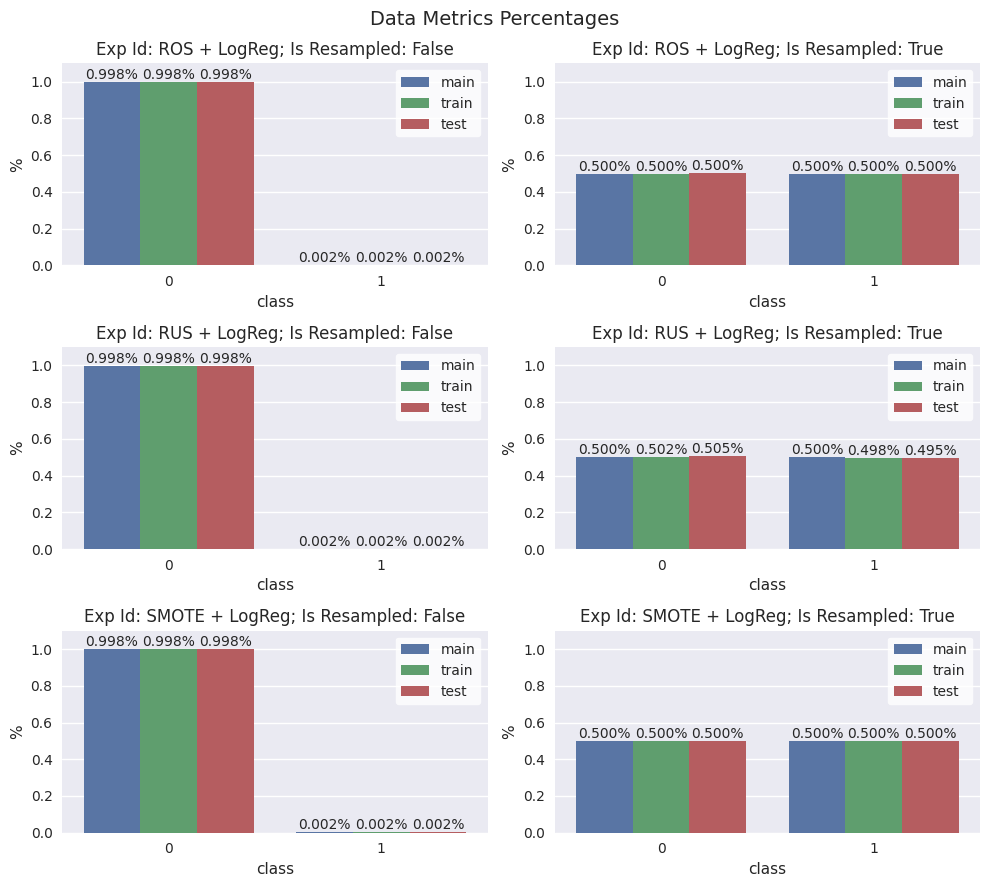

In [7]:
_ = plt.figure(figsize=[10, 9])
plt.suptitle('Data Metrics Percentages', fontsize=14)
FMT = '%.3f%%'

for i, exp in enumerate(df_data['exp_id'].unique()):
    data = df_data[df_data['exp_id'] == exp]
    
    index = (i * 2) + 1
    
    plt.subplot(3,2,index)
    ros_log_original = data[~data['is_resampled']]
    ax = sns.barplot(
        data=ros_log_original, 
        x='class', 
        y='percent',
        hue='subset')
    for container in ax.containers:
        ax.bar_label(container, fmt=FMT)
    ax.set_ylabel('%')
    plt.ylim([0, 1.1])
    plt.title(f'Exp Id: {exp}; Is Resampled: False')
    legend = plt.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_color('white')

    plt.subplot(3,2,index+1)
    ros_log_resampled = data[data['is_resampled']]
    ax = sns.barplot(
        data=ros_log_resampled, 
        x='class', 
        y='percent',
        hue='subset')
    for container in ax.containers:
        ax.bar_label(container, fmt=FMT)
    ax.set_ylabel('%')
    plt.ylim([0, 1.1])
    plt.title(f'Exp Id: {exp}; Is Resampled: True')
    legend = plt.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_color('white')

plt.tight_layout()

## Model Metrics <a class="anchor" id="2-bullet"></a>

In [8]:
data_to_create_df = [record['message']['data'] for record in raw_model_data['result']]
pd.DataFrame(data_to_create_df)

,exp_id,f_score,g_mean,is_resampled,precision,recall,roc_auc_score
0,ROS + LogReg,0.703125,0.777121,False,0.841121,0.604027,0.801923
1,ROS + LogReg,0.936577,0.937871,True,0.962956,0.911604,0.938249
2,RUS + LogReg,0.703125,0.777121,False,0.841121,0.604027,0.801923
3,RUS + LogReg,0.929936,0.931733,True,0.954248,0.906832,0.932075
4,SMOTE + LogReg,0.703125,0.777121,False,0.841121,0.604027,0.801923
5,SMOTE + LogReg,0.957428,0.957780,True,0.967042,0.948004,0.957830
